In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings 
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
# 메트플로립세팅
plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)
%matplotlib inline

In [7]:
def get_outlier(df=None, column=None, weight=1.5):
    import numpy as np
 

    fraud = df[column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
        
    return outlier_index

def remove_outlier(df=None,column_list=None,weight=1.5):
    df_copy = df.copy()
    outlier_index_set = set()
    
    for column_name in column_list:
        outlier_index = get_outlier(df=df_copy, column=column_name, weight=weight)
        outlier_index_set = outlier_index_set | set(outlier_index)
    
    df_copy.drop(list(outlier_index_set),inplace=True)
    
    return df_copy[column_list]
    

In [8]:
for m in tqdm(range(1,10),desc='월단위 진행'):
    globals()["ts{}".format(m)] = pd.read_csv(f'./data/2022.{m}월_29개 통신정보.csv',encoding='cp949')
    try : 
        globals()["ts{}".format(m)].drop(columns=['행정동코드','행정동','총인구수','1인가구수'],inplace=True)    
    except:
        globals()["ts{}".format(m)].drop(columns=['행정동코드','행정동명','총인구','1인가구수'],inplace=True)  
    globals()["ts{}".format(m)].drop(columns=globals()["ts{}".format(m)].filter(like='4분위수'),inplace=True)
    globals()["ts{}".format(m)].drop(columns=globals()["ts{}".format(m)].filter(like='인구'),inplace=True) #미추정
    
    # 데이터가 평균값을 제시하고 그 외 4분위 관련 수치를 따로 제공해주고 있음 -> 이미 전처리가 되어있는 거 같음..?
    globals()["ts{}".format(m)]['연령대_1'] = globals()["ts{}".format(m)]['연령대']//10*10
    globals()["ts{}".format(m)]['월'] = int(m)
    fix = globals()["ts{}".format(m)][['월','연령대','연령대_1','자치구','성별']]
    uni = ['상주지','출근','근무','소액결재','연체','카카오톡','SNS','통화','문자','데이터','이동','체류','지하철','게임','금융','쇼핑','동영상','유튜브','넷플릭스','배달']
    
    for col in tqdm(uni,desc=f'{m}월'):
        globals()["{}_{}".format(col,m)] = pd.concat([fix,globals()["ts{}".format(m)].filter(like=col)],axis=1)    
        
        
for col in tqdm(uni,desc='카테고리별로 합치기'):
    globals()["{}".format(col)] = pd.DataFrame()
    for m in range(1,10):
        globals()["이동_{}".format(m)].drop(columns= globals()["이동_{}".format(m)].filter(like='지하철'),inplace=True)
        globals()["{}".format(col)]= pd.concat([globals()["{}".format(col)],globals()["{}_{}".format(col,m)]])

월단위 진행:   0%|          | 0/9 [00:00<?, ?it/s]

1월:   0%|          | 0/20 [00:00<?, ?it/s]

2월:   0%|          | 0/20 [00:00<?, ?it/s]

3월:   0%|          | 0/20 [00:00<?, ?it/s]

4월:   0%|          | 0/20 [00:00<?, ?it/s]

5월:   0%|          | 0/20 [00:00<?, ?it/s]

6월:   0%|          | 0/20 [00:00<?, ?it/s]

7월:   0%|          | 0/20 [00:00<?, ?it/s]

8월:   0%|          | 0/20 [00:00<?, ?it/s]

9월:   0%|          | 0/20 [00:00<?, ?it/s]

카테고리별로 합치기:   0%|          | 0/20 [00:00<?, ?it/s]

In [9]:
df = pd.concat([ts1,ts2,ts3,ts4,ts5,ts6,ts7,ts8,ts9],axis=0,ignore_index=True)


In [10]:
df.columns

Index(['자치구', '성별', '연령대', '야간상주지 변경횟수 평균', '주간상주지 변경횟수 평균', '평균 출근 소요시간 평균',
       '평균 근무시간 평균', '소액결재 사용횟수 평균', '소액결재 사용금액 평균', '최근 3개월 내 요금 연체 비율',
       'SNS 사용횟수', '평균 통화량', '평균 문자량', '평균 통화대상자 수', '평균 문자대상자 수', '데이터 사용량',
       '평일 총 이동 횟수', '휴일 총 이동 횟수 평균', '집 추정 위치 평일 총 체류시간', '집 추정 위치 휴일 총 체류시간',
       '평일 총 이동 거리 합계', '휴일 총 이동 거리 합계', '지하철이동일수 합계', '게임 서비스 사용일수',
       '금융 서비스 사용일수', '쇼핑 서비스 사용일수', '동영상/방송 서비스 사용일수', '유튜브 사용일수',
       '넷플릭스 사용일수', '배달 서비스 사용일수', '배달_브랜드 서비스 사용일수', '배달_식재료 서비스 사용일수',
       '연령대_1', '월'],
      dtype='object')

In [11]:
df_main = df[['게임 서비스 사용일수','금융 서비스 사용일수','쇼핑 서비스 사용일수','동영상/방송 서비스 사용일수','배달 서비스 사용일수']]

In [12]:
df_main

,게임 서비스 사용일수,금융 서비스 사용일수,쇼핑 서비스 사용일수,동영상/방송 서비스 사용일수,배달 서비스 사용일수
0,67.0,82.8,72.1,28.0,10.3
1,66.1,109.3,103.6,31.2,13.9
2,57.5,130.2,121.7,30.1,13.8
3,51.7,123.2,121.4,28.1,11.2
4,47.6,122.2,118.0,28.9,9.3
...,...,...,...,...,...
91579,40.7,61.5,96.0,15.1,9.6
91580,37.2,45.5,68.0,13.9,8.9
91581,36.5,36.6,52.6,12.5,7.6
91582,31.2,26.2,36.4,10.2,5.2


In [13]:
df_main.mean()

게임 서비스 사용일수         45.815114
금융 서비스 사용일수         75.301662
쇼핑 서비스 사용일수        100.600961
동영상/방송 서비스 사용일수     20.854104
배달 서비스 사용일수         10.851049
dtype: float64

In [14]:
df_main.describe()

,게임 서비스 사용일수,금융 서비스 사용일수,쇼핑 서비스 사용일수,동영상/방송 서비스 사용일수,배달 서비스 사용일수
count,91584.000000,91584.000000,91584.000000,91584.000000,91584.000000
mean,45.815114,75.301662,100.600961,20.854104,10.851049
std,13.939530,37.144763,50.974423,7.918183,4.161685
min,20.400000,3.900000,7.900000,2.500000,0.000000
25%,35.700000,39.700000,51.200000,13.600000,7.800000
50%,41.400000,78.300000,101.900000,20.600000,10.600000
75%,55.400000,105.600000,143.500000,27.700000,14.000000
max,109.800000,231.100000,310.000000,68.300000,36.700000


In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_main)

MinMaxScaler()

In [16]:
df_main = scaler.transform(df_main)

In [17]:
df_main_MMS= pd.DataFrame(df_main, columns = ['게임 서비스 사용일수','금융 서비스 사용일수','쇼핑 서비스 사용일수','동영상/방송 서비스 사용일수','배달 서비스 사용일수'])

In [184]:
df_main_MMS

,게임 서비스 사용일수,금융 서비스 사용일수,쇼핑 서비스 사용일수,동영상/방송 서비스 사용일수,배달 서비스 사용일수
0,0.521253,0.347271,0.212512,0.387538,0.280654
1,0.511186,0.463908,0.316783,0.436170,0.378747
2,0.414989,0.555898,0.376696,0.419453,0.376022
3,0.350112,0.525088,0.375703,0.389058,0.305177
4,0.304251,0.520687,0.364449,0.401216,0.253406
...,...,...,...,...,...
91579,0.227069,0.253521,0.291625,0.191489,0.261580
91580,0.187919,0.183099,0.198941,0.173252,0.242507
91581,0.180089,0.143926,0.147964,0.151976,0.207084
91582,0.120805,0.098151,0.094340,0.117021,0.141689


In [185]:
df_main_MMS.describe()

,게임 서비스 사용일수,금융 서비스 사용일수,쇼핑 서비스 사용일수,동영상/방송 서비스 사용일수,배달 서비스 사용일수
count,91584.000000,91584.000000,91584.000000,91584.000000,91584.000000
mean,0.284285,0.314268,0.306855,0.278938,0.295669
std,0.155923,0.163489,0.168734,0.120337,0.113397
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.171141,0.157570,0.143330,0.168693,0.212534
50%,0.234899,0.327465,0.311155,0.275076,0.288828
75%,0.391499,0.447623,0.448858,0.382979,0.381471
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
# 게임, 금융, 쇼핑, 동영상, 배달
most_list = []
for x_list in df_main :
    x_list = list(x_list)
    most_list.append(x_list.index(max(x_list)))

In [19]:
df['광고'] = most_list

In [20]:
df.groupby('광고').count()

,자치구,성별,연령대,야간상주지 변경횟수 평균,주간상주지 변경횟수 평균,평균 출근 소요시간 평균,평균 근무시간 평균,소액결재 사용횟수 평균,소액결재 사용금액 평균,최근 3개월 내 요금 연체 비율,...,금융 서비스 사용일수,쇼핑 서비스 사용일수,동영상/방송 서비스 사용일수,유튜브 사용일수,넷플릭스 사용일수,배달 서비스 사용일수,배달_브랜드 서비스 사용일수,배달_식재료 서비스 사용일수,연령대_1,월
광고,,,,,,,,,,,,,,,,,,,,,
0,20358,20358,20358,20358,20358,20358,20358,20358,20358,20358,...,20358,20358,20358,20358,20358,20358,20358,20358,20358,20358
1,17410,17410,17410,17410,17410,17410,17410,17410,17410,17410,...,17410,17410,17410,17410,17410,17410,17410,17410,17410,17410
2,25286,25286,25286,25286,25286,25286,25286,25286,25286,25286,...,25286,25286,25286,25286,25286,25286,25286,25286,25286,25286
3,4591,4591,4591,4591,4591,4591,4591,4591,4591,4591,...,4591,4591,4591,4591,4591,4591,4591,4591,4591,4591
4,23939,23939,23939,23939,23939,23939,23939,23939,23939,23939,...,23939,23939,23939,23939,23939,23939,23939,23939,23939,23939


In [21]:
df.columns

Index(['자치구', '성별', '연령대', '야간상주지 변경횟수 평균', '주간상주지 변경횟수 평균', '평균 출근 소요시간 평균',
       '평균 근무시간 평균', '소액결재 사용횟수 평균', '소액결재 사용금액 평균', '최근 3개월 내 요금 연체 비율',
       'SNS 사용횟수', '평균 통화량', '평균 문자량', '평균 통화대상자 수', '평균 문자대상자 수', '데이터 사용량',
       '평일 총 이동 횟수', '휴일 총 이동 횟수 평균', '집 추정 위치 평일 총 체류시간', '집 추정 위치 휴일 총 체류시간',
       '평일 총 이동 거리 합계', '휴일 총 이동 거리 합계', '지하철이동일수 합계', '게임 서비스 사용일수',
       '금융 서비스 사용일수', '쇼핑 서비스 사용일수', '동영상/방송 서비스 사용일수', '유튜브 사용일수',
       '넷플릭스 사용일수', '배달 서비스 사용일수', '배달_브랜드 서비스 사용일수', '배달_식재료 서비스 사용일수',
       '연령대_1', '월', '광고'],
      dtype='object')

In [22]:
df_commercial = remove_outlier(df,['성별', '연령대', '야간상주지 변경횟수 평균', '주간상주지 변경횟수 평균', '평균 출근 소요시간 평균',
       '평균 근무시간 평균', '소액결재 사용횟수 평균', '소액결재 사용금액 평균', '최근 3개월 내 요금 연체 비율',
       'SNS 사용횟수', '평균 통화량', '평균 문자량', '평균 통화대상자 수', '평균 문자대상자 수', '데이터 사용량',
       '평일 총 이동 횟수', '휴일 총 이동 횟수 평균', '집 추정 위치 평일 총 체류시간', '집 추정 위치 휴일 총 체류시간',
       '평일 총 이동 거리 합계', '휴일 총 이동 거리 합계', '지하철이동일수 합계',
       '광고'])

In [23]:
df_commercial.reset_index(drop=True)

,성별,연령대,야간상주지 변경횟수 평균,주간상주지 변경횟수 평균,평균 출근 소요시간 평균,평균 근무시간 평균,소액결재 사용횟수 평균,소액결재 사용금액 평균,최근 3개월 내 요금 연체 비율,SNS 사용횟수,...,평균 문자대상자 수,데이터 사용량,평일 총 이동 횟수,휴일 총 이동 횟수 평균,집 추정 위치 평일 총 체류시간,집 추정 위치 휴일 총 체류시간,평일 총 이동 거리 합계,휴일 총 이동 거리 합계,지하철이동일수 합계,광고
0,1,30,2.2,3.1,57.4,532.4,2.7,7071.4,9.88,0.2,...,6.0,15.6,30.3,12.5,1088849.3,283056.3,770.0,469.4,13.4,1
1,1,35,2.0,2.7,61.6,540.8,2.4,7072.9,11.95,0.1,...,6.5,9.9,32.1,11.2,1046963.5,260515.6,880.9,404.4,13.6,1
2,1,40,1.9,2.6,69.3,554.7,2.8,5655.2,4.62,0.1,...,7.2,9.7,32.6,10.4,1032486.6,256332.5,1056.6,429.5,13.6,1
3,1,45,1.8,2.5,71.1,530.8,2.5,7657.3,7.42,0.0,...,7.5,6.5,33.9,11.5,1057874.6,274477.2,1009.6,462.1,13.8,1
4,1,50,1.8,2.3,63.2,541.5,2.5,6925.3,6.44,0.0,...,7.4,5.2,32.4,10.8,1091039.7,270222.1,968.2,414.9,12.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66763,2,45,1.5,2.8,61.9,506.4,2.5,7867.9,8.47,0.0,...,6.3,3.4,19.2,7.0,782104.7,210961.3,470.8,247.9,7.7,2
66764,2,50,1.5,2.7,62.2,508.7,2.3,7943.0,8.22,-0.1,...,5.9,2.0,18.7,7.2,802507.6,215252.3,482.8,278.7,7.7,2
66765,2,55,1.5,2.7,56.7,502.5,2.3,6623.8,6.68,-0.1,...,5.2,1.8,17.8,7.1,808537.2,219461.6,417.5,258.7,7.3,2
66766,2,60,1.5,2.8,60.8,486.8,2.6,6711.4,6.55,-0.1,...,4.5,1.2,16.2,6.3,858379.3,233121.0,375.8,228.9,6.7,4


In [24]:
df_commercial.groupby(['광고','연령대']).count()
# 게임, 금융, 쇼핑, 동영상, 배달 

성별  야간상주지 변경횟수 평균  주간상주지 변경횟수 평균  평균 출근 소요시간 평균  평균 근무시간 평균  \
광고 연령대                                                                  
0  20    589            589            589            589         589   
   25   2160           2160           2160           2160        2160   
   30   1185           1185           1185           1185        1185   
   35    575            575            575            575         575   
   40    981            981            981            981         981   
   45   1449           1449           1449           1449        1449   
   50   1295           1295           1295           1295        1295   
   55   1632           1632           1632           1632        1632   
   60   2182           2182           2182           2182        2182   
   65   1431           1431           1431           1431        1431   
   70      2              2              2              2           2   
1  20     96             96             96             96          96   
   25    655            655            655            655         655   
   30   2579           2579           2579           2579        2579   
   35   2966           2966           2966           2966        2966   
   40   2401           2401           2401           2401        2401   
   45   1867           1867           1867           1867        1867   
   50   2305           2305           2305           2305        2305   
   55   2197           2197           2197           2197        2197   
   60    666            666            666            666         666   
   65     48             48             48             48          48   
2  20    155            155            155            155         155   
   25   2232           2232           2232           2232        2232   
   30   3423           3423           3423           3423        3423   
   35   3772           3772           3772           3772        3772   
   40   3912           3912           3912           3912        3912   
   45   3854           3854           3854           3854        3854   
   50   3547           3547           3547           3547        3547   
   55   2633           2633           2633           2633        2633   
   60    824            824            824            824         824   
   65    129            129            129            129         129   
3  20    120            120            120            120         120   
   25     91             91             91             91          91   
   30     26             26             26             26          26   
   40      4              4              4              4           4   
   45     13             13             13             13          13   
   50     35             35             35             35          35   
   55    256            256            256            256         256   
   60    827            827            827            827         827   
   65    744            744            744            744         744   
   70      3              3              3              3           3   
4  20   2776           2776           2776           2776        2776   
   25    782            782            782            782         782   
   30     72             72             72             72          72   
   35     20             20             20             20          20   
   45      7              7              7              7           7   
   50     20             20             20             20          20   
   55    436            436            436            436         436   
   60   2670           2670           2670           2670        2670   
   65   4107           4107           4107           4107        4107   
   70     17             17             17             17          17   

        소액결재 사용횟수 평균  소액결재 사용금액 평균  최근 3개월 내 요금 연체 비율  SNS 사용횟수  평균 통화량  ...  \
광고 연령대                                                      

DT accuracy : 0.7564774599370975 
DT f1(macro) : 0.6453682191035714 
DT logloss : 8.410970558353272

RF accuracy : 0.8303878987569268 
RF f1(macro) : 0.7234583144260078 
RF logloss : 0.4793511942674987



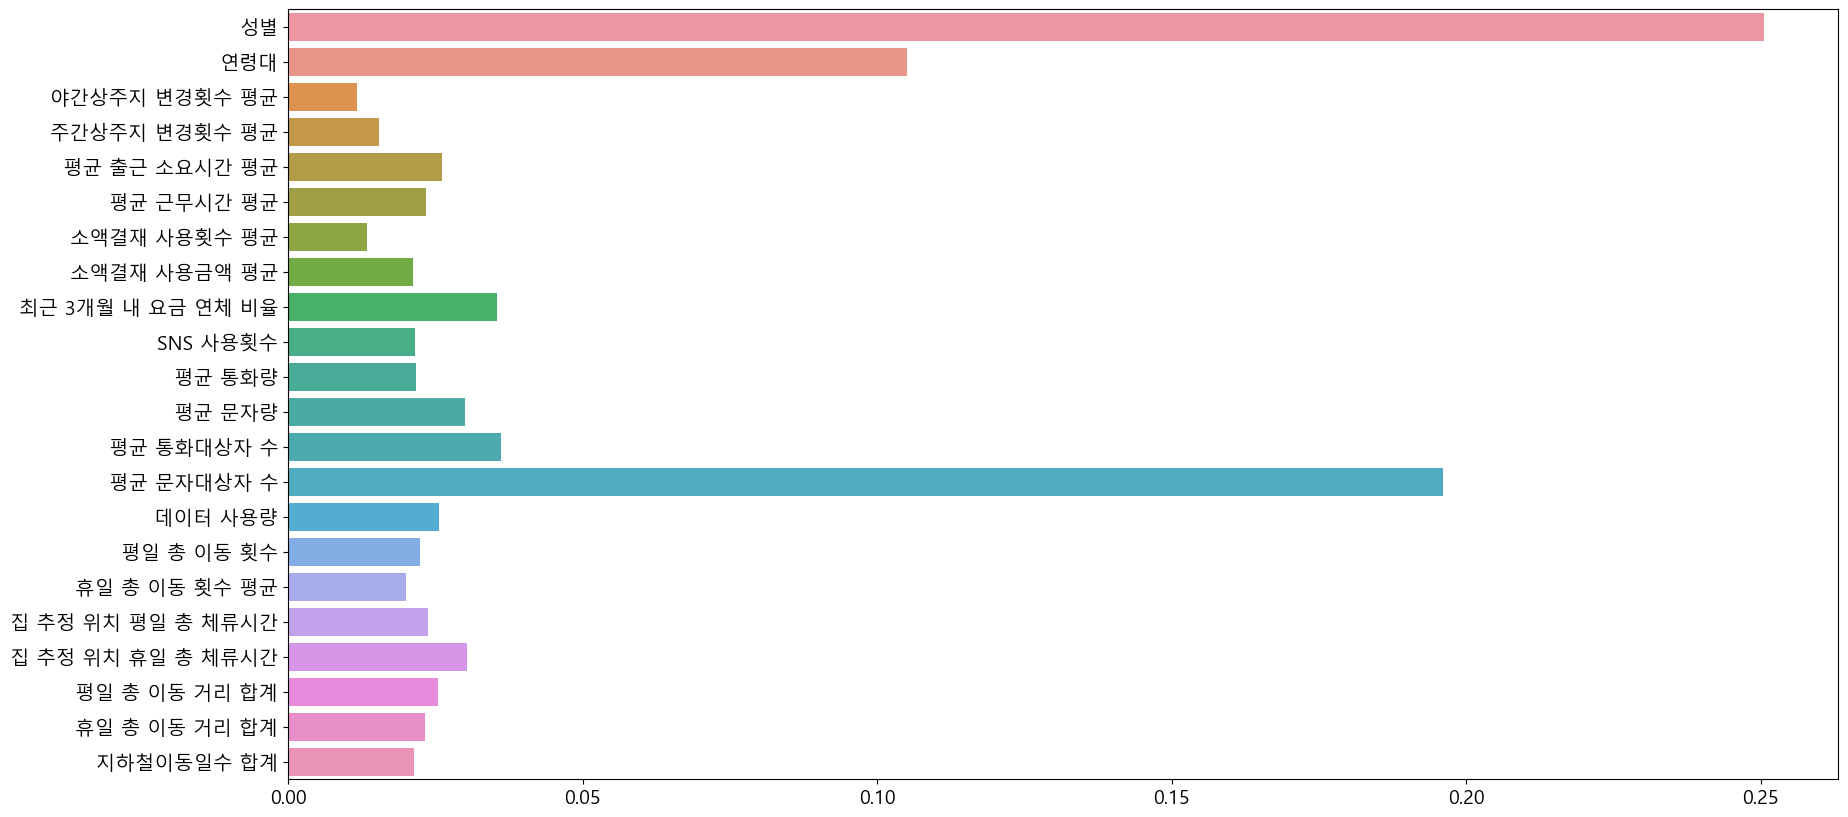

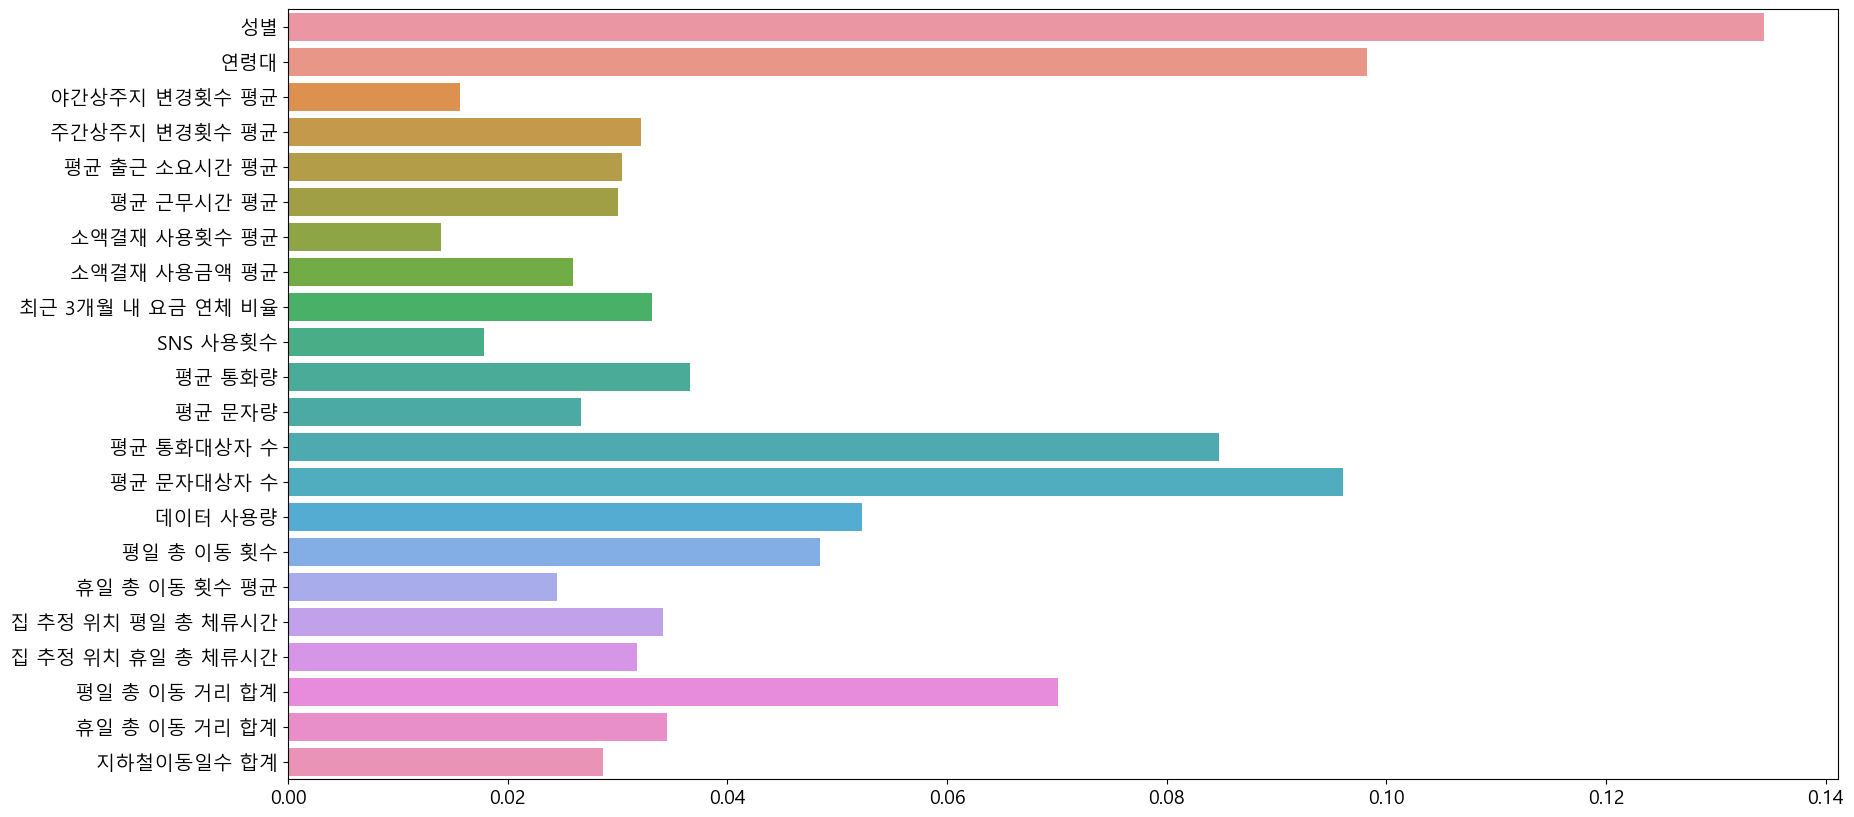

In [193]:
#df, rf

# 전체 데이터 학습,  테스트 모델
y = df_commercial[['광고']]
X = df_commercial.drop(columns='광고')

X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2)
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
pred_dt = dt.predict(X_test)
pred_proba_dt = dt.predict_proba(X_test)

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
pred_rf = rf.predict(X_test)
pred_proba_rf = rf.predict_proba(X_test)


ax = plt.subplots(figsize=(20, 10))
ax = sns.barplot(x = dt.feature_importances_ , y = X.columns)


ax = plt.subplots(figsize=(20, 10))
ax = sns.barplot(x = rf.feature_importances_ , y = X.columns)


print(f'DT accuracy : {accuracy_score(y_test,pred_dt)} \nDT f1(macro) : {f1_score(y_test,pred_dt,average="macro")} \nDT logloss : {log_loss(y_test,pred_proba_dt)}\n')
print(f'RF accuracy : {accuracy_score(y_test,pred_rf)} \nRF f1(macro) : {f1_score(y_test,pred_rf,average="macro")} \nRF logloss : {log_loss(y_test,pred_proba_rf)}\n')

In [25]:
# 전체 데이터 학습,  테스트 모델
y = df_commercial[['광고']]
X = df_commercial.drop(columns='광고')


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_tr, X_val, y_tr, y_val = train_test_split(X_train,y_train,test_size=0.2)

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
xgb_clf = XGBClassifier(n_estimators=1000,learning_rate = 0.02)
xgb_clf.fit(X_tr,y_tr,early_stopping_rounds=100,eval_set=[(X_tr,y_tr),(X_val,y_val)])



pred = xgb_clf.predict(X_test)
pred_proba = xgb_clf.predict_proba(X_test)

print(f'accuracy : {accuracy_score(y_test,pred)} \nf1(macro) : {f1_score(y_test,pred,average="macro")} \nlogloss : {log_loss(y_test,pred_proba)}\n')

[0]	validation_0-mlogloss:1.57840	validation_1-mlogloss:1.57879
[1]	validation_0-mlogloss:1.54878	validation_1-mlogloss:1.54953
[2]	validation_0-mlogloss:1.52040	validation_1-mlogloss:1.52152
[3]	validation_0-mlogloss:1.49324	validation_1-mlogloss:1.49469
[4]	validation_0-mlogloss:1.46715	validation_1-mlogloss:1.46890
[5]	validation_0-mlogloss:1.44210	validation_1-mlogloss:1.44427
[6]	validation_0-mlogloss:1.41794	validation_1-mlogloss:1.42052
[7]	validation_0-mlogloss:1.39453	validation_1-mlogloss:1.39743
[8]	validation_0-mlogloss:1.37199	validation_1-mlogloss:1.37520
[9]	validation_0-mlogloss:1.35023	validation_1-mlogloss:1.35378
[10]	validation_0-mlogloss:1.32928	validation_1-mlogloss:1.33312
[11]	validation_0-mlogloss:1.30901	validation_1-mlogloss:1.31318
[12]	validation_0-mlogloss:1.28943	validation_1-mlogloss:1.29391
[13]	validation_0-mlogloss:1.27050	validation_1-mlogloss:1.27528
[14]	validation_0-mlogloss:1.25215	validation_1-mlogloss:1.25723
[15]	validation_0-mlogloss:1.23439	

KeyboardInterrupt: 

In [35]:
from hyperopt import hp
from xgboost import XGBClassifier
from hyperopt import STATUS_OK
import warnings
warnings.filterwarnings('ignore')

In [40]:
def objective_func(search_space):
    from sklearn.model_selection import cross_val_score
    Xgb_clf = XGBClassifier(n_estimators = 100,
                            max_depth = int(search_space['max_depth']),
                            min_child_weight = int(search_space['min_child_weight']),
                            learning_rate = search_space['learning_rate'],
                            colsample_bytree = search_space['colsample_bytree'],
                            eval_metric='mlogloss')
    
    accuracy = cross_val_score(Xgb_clf,X_train,y_train,scoring = 'accuracy', cv=3)
    # scoring = 'accuracy' -> 정확도가 나오는 듯 하다
    # scoring = 'logloss' -> 0에 가까울 수록 좋다, -log 확률  로, log 1 = 0 임을 이용한 수치, 
    
    return {'loss': -1 * np.mean(accuracy),'status':STATUS_OK}
    # scoring = 'accuracy' 를 작아지면 좋게 판단하기 위해 -1 를 곱한다.
    #딕션어리 형식으로 리턴


In [41]:
# 전체 데이터 학습,  테스트 모델
y = df_commercial[['광고']]
X = df_commercial.drop(columns='광고')



X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [42]:
from hyperopt import hp

# max_depth는 5에서 15까지 1간격으로, min_child_weight는 1에서 6까지 1간격으로
# colsample_bytree는 0.5에서 0.95사이, learning_rate는 0.01에서 0.2사이 정규 분포된 값으로 검색.

xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 15, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
                    # quniform uniform 정수 실수수
}


# ctrl+shift+ -  분리

In [43]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score


# trial, best loss: -0.6977974081481776]
# best: {'colsample_bytree': 0.8835889922712005, 'learning_rate': 0.11646324628405799, 'max_depth': 6.0, 'min_child_weight': 2.0}


from hyperopt import fmin, tpe, Trials

trials = Trials()
# fmin()함수를 호출. max_evals지정된 횟수만큼 반복 후 목적함수의 최소값을 가지는 최적 입력값 추출.
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials, rstate=np.random.default_rng(seed=30))

print('best:', best)
# best: {'colsample_bytree': 0.8478996435024565, 'learning_rate': 0.16832595499187503, 'max_depth': 12.0, 'min_child_weight': 1.0}

  0%|                                                                           | 0/50 [00:03<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [138]:

y = df_commercial[['광고']]
X = df_commercial.drop(columns='광고')



X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_tr, X_val, y_tr, y_val = train_test_split(X_train,y_train,test_size=0.1)
model = XGBClassifier(n_estimators = 1000,
                      learning_rate =round(best['learning_rate'],5),
                      max_depth=int(best['max_depth']),
                      min_child_weight=int(best['min_child_weight']),
                      colsample_bytree=round(best['colsample_bytree'],5),
                      objective='multi:softmax'
                 
                     )

evals=[(X_tr,y_tr),(X_val,y_val)]
model.fit(X_tr,
          y_tr,
          verbose=True,
          eval_set=evals,
          early_stopping_rounds=100,
          eval_metric='mlogloss')
pred = model.predict(X_test)
accuracy_score(y_test,pred)

[0]	validation_0-mlogloss:1.42624	validation_1-mlogloss:1.45412
[1]	validation_0-mlogloss:1.27690	validation_1-mlogloss:1.32951
[2]	validation_0-mlogloss:1.15207	validation_1-mlogloss:1.22578
[3]	validation_0-mlogloss:1.04600	validation_1-mlogloss:1.14161
[4]	validation_0-mlogloss:0.95222	validation_1-mlogloss:1.06610
[5]	validation_0-mlogloss:0.87022	validation_1-mlogloss:1.00108
[6]	validation_0-mlogloss:0.79835	validation_1-mlogloss:0.94489
[7]	validation_0-mlogloss:0.73337	validation_1-mlogloss:0.89454
[8]	validation_0-mlogloss:0.67463	validation_1-mlogloss:0.84958
[9]	validation_0-mlogloss:0.62321	validation_1-mlogloss:0.81123
[10]	validation_0-mlogloss:0.57623	validation_1-mlogloss:0.77611
[11]	validation_0-mlogloss:0.53377	validation_1-mlogloss:0.74442
[12]	validation_0-mlogloss:0.49522	validation_1-mlogloss:0.71575
[13]	validation_0-mlogloss:0.45983	validation_1-mlogloss:0.68996
[14]	validation_0-mlogloss:0.42799	validation_1-mlogloss:0.66729
[15]	validation_0-mlogloss:0.39847	

0.8248464879436873

In [139]:
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)

print(f'accuracy : {accuracy_score(y_test,pred)} \nf1(macro) : {f1_score(y_test,pred,average="macro")} \nlogloss : {log_loss(y_test,pred_proba)}\n')

accuracy : 0.8248464879436873 
f1(macro) : 0.7240476646954391 
logloss : 0.4510204196271175



In [140]:
from sklearn.metrics import classification_report
print(f'accuracy : {accuracy_score(y_test,pred)} \nDT f1(macro) : {f1_score(y_test,pred,average="macro")} \nDT logloss : {log_loss(y_test,pred_proba)}\n')
print(classification_report(y_test,pred))


accuracy : 0.8248464879436873 
DT f1(macro) : 0.7240476646954391 
DT logloss : 0.4510204196271175

              precision    recall  f1-score   support

           0       0.76      0.71      0.73      2751
           1       0.82      0.82      0.82      3199
           2       0.93      0.94      0.94      4824
           3       0.55      0.27      0.36       417
           4       0.72      0.83      0.77      2163

    accuracy                           0.82     13354
   macro avg       0.76      0.71      0.72     13354
weighted avg       0.82      0.82      0.82     13354



In [43]:
y_test.values

array([[2],
       [1],
       [0],
       ...,
       [4],
       [1],
       [0]], dtype=int64)

In [47]:
list_y = []
for x in y_test.values:
    list_y.append(x[0])

In [48]:
list_y

[2,
 1,
 0,
 4,
 1,
 2,
 1,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 1,
 0,
 2,
 2,
 2,
 1,
 2,
 3,
 4,
 2,
 1,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 1,
 2,
 4,
 0,
 2,
 3,
 2,
 1,
 2,
 0,
 4,
 0,
 4,
 1,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 2,
 2,
 4,
 4,
 1,
 1,
 1,
 0,
 2,
 2,
 1,
 0,
 2,
 1,
 2,
 0,
 2,
 2,
 1,
 2,
 3,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 4,
 0,
 4,
 1,
 1,
 0,
 1,
 2,
 1,
 4,
 2,
 4,
 4,
 1,
 0,
 1,
 4,
 2,
 0,
 1,
 2,
 1,
 2,
 2,
 2,
 3,
 0,
 0,
 1,
 4,
 2,
 1,
 2,
 1,
 1,
 1,
 4,
 1,
 1,
 0,
 2,
 2,
 0,
 4,
 0,
 1,
 0,
 0,
 0,
 4,
 2,
 2,
 4,
 2,
 4,
 3,
 4,
 0,
 4,
 2,
 4,
 0,
 1,
 2,
 1,
 2,
 2,
 4,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 4,
 2,
 4,
 2,
 2,
 4,
 2,
 1,
 2,
 2,
 4,
 2,
 1,
 4,
 1,
 0,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 4,
 0,
 4,
 2,
 2,
 1,
 1,
 1,
 2,
 0,
 2,
 0,
 1,
 0,
 4,
 2,
 2,
 1,
 4,
 0,
 0,
 1,
 1,
 0,
 0,
 4,
 4,
 2,
 2,
 4,
 1,
 2,
 4,
 0,
 2,
 0,
 3,
 1,
 2,
 1,
 0,
 4,
 2,
 2,
 1,
 2,
 2,
 1,
 4,
 2,
 1,
 0,
 0,
 4,
 2,
 3,
 1,
 2,
 4,
 4,
 2,
 1,
 0,
 1,


In [38]:
zip_list = zip(y_test,pred)

In [40]:
list(zip_list)

[('광고', 2)]

In [50]:
list_pred = []
for x in pred:
    list_pred.append(x)

In [51]:
list_pred

[2,
 1,
 0,
 4,
 1,
 2,
 1,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 1,
 2,
 4,
 4,
 2,
 1,
 4,
 2,
 2,
 4,
 0,
 2,
 2,
 2,
 1,
 2,
 0,
 0,
 2,
 0,
 2,
 1,
 2,
 0,
 4,
 0,
 4,
 1,
 1,
 1,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 4,
 2,
 1,
 1,
 2,
 0,
 2,
 4,
 0,
 0,
 2,
 1,
 2,
 0,
 2,
 2,
 1,
 2,
 0,
 2,
 4,
 2,
 0,
 4,
 0,
 0,
 4,
 0,
 4,
 1,
 1,
 1,
 1,
 2,
 1,
 4,
 2,
 2,
 4,
 0,
 0,
 1,
 0,
 2,
 0,
 1,
 2,
 1,
 2,
 2,
 2,
 3,
 0,
 0,
 4,
 4,
 2,
 1,
 2,
 1,
 1,
 1,
 4,
 0,
 1,
 4,
 2,
 2,
 0,
 4,
 4,
 1,
 0,
 0,
 4,
 4,
 4,
 2,
 4,
 2,
 4,
 0,
 0,
 1,
 4,
 2,
 0,
 0,
 1,
 2,
 1,
 4,
 2,
 4,
 1,
 0,
 1,
 1,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 4,
 2,
 4,
 2,
 2,
 4,
 2,
 1,
 2,
 2,
 4,
 2,
 1,
 4,
 1,
 0,
 1,
 4,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 4,
 0,
 2,
 2,
 2,
 2,
 1,
 1,
 2,
 0,
 2,
 0,
 1,
 0,
 1,
 2,
 2,
 1,
 4,
 0,
 1,
 1,
 1,
 0,
 1,
 4,
 4,
 2,
 2,
 4,
 1,
 2,
 4,
 4,
 2,
 0,
 4,
 1,
 2,
 1,
 1,
 4,
 2,
 2,
 1,
 2,
 2,
 2,
 4,
 2,
 1,
 4,
 0,
 0,
 2,
 3,
 1,
 2,
 2,
 4,
 2,
 1,
 4,
 1,
